In [1]:
### Imports, functions and global variables
import sys
import os
import re
from bs4 import BeautifulSoup as Soup
from collections import Counter
from collections import defaultdict
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from pyspark.mllib.fpm import FPGrowth

## Global variables

totalquestions=0
totalQuestionswithacceptedanswers=0
totalQuestionswithnoacceptedanswers=0
bodydict=dict()

posts_by_tag = defaultdict()
tags_by_year = defaultdict()
tags_by_post_id = defaultdict()
userdict=dict()
tags=list()

acceptedanswers=list()
bestuser=list()

def populate_posts_by_tag(tag,post_id):
    global posts_by_tag
    if tag == '':
        return
    if post_id == '':
        return

    if tag not in posts_by_tag:
        posts_by_tag[tag] = set()
    posts_by_tag[tag].add(int(post_id))

def populate_tags_by_post_id(id,tag):
    global tags_by_post_id
    if tag == '':
        return
    if id == '':
        return

    if id not in tags_by_post_id:
        tags_by_post_id[id] = list()
    tags_by_post_id[id].append(tag)
    
def populate_tags_by_year(tag,year):
    global tags_by_year
    if tag == '':
        return
    if year == '':
        return

    if tag not in tags_by_year:
        tags_by_year[tag] = list()
    tags_by_year[tag].append(year)

def plot_tags(tagCount):
    
    x,y = zip(*tagCount)

    colormap = plt.cm.gist_ncar #nipy_spectral, Set1,Paired  
    colors = [colormap(i) for i in np.linspace(0, 0.8,50)]   

    area = [i/100 for i in list(y)]   # 0 to 15 point radiuses
    plt.figure(figsize=(8,8))
    plt.ylabel("Number of question associations")
    for i in range(len(y)):
        plt.plot(i+0.5,y[i], marker='o', linestyle='',ms=area[i],label=x[i])

    plt.legend(numpoints=1)
    plt.show()
    
def parse_posts(file):
    global totalquestions,totalQuestionswithacceptedanswers,totalQuestionswithnoacceptedanswers,bodydict

    count=0
    with open(file, encoding='utf8') as handler:
        soup = Soup(handler,"html.parser")
        for message in soup.findAll('row'):
            msg_attrs = dict(message.attrs)
            id = msg_attrs['id']     

            if 'tags' in msg_attrs:
                year =  msg_attrs['creationdate'].split("-")[0]
                #print(year)
                msg_attrs=(msg_attrs[u'tags'].replace('<','').replace('>',','))
                for msg in msg_attrs.split(','):
                    tags.append(msg)
                    populate_posts_by_tag(msg,id)
                    populate_tags_by_year(msg,year)
                    populate_tags_by_post_id(id,msg)
            
            msg_attrs = dict(message.attrs)
            posttypeid = msg_attrs['posttypeid']
            
            # Questions only, no answers
            if posttypeid == "1":
                totalquestions+=1
                if 'body' in msg_attrs:
                    #id=(msg_attrs[u'id'])
                    body=(msg_attrs[u'body'])
                    bodydict[id]=Soup(body,"html.parser").getText()
                
                if 'acceptedanswerid' in msg_attrs:
                    totalQuestionswithacceptedanswers+=1
                    acceptedanswerid = msg_attrs['acceptedanswerid']
                    acceptedanswers.append(acceptedanswerid)
                else:
                    totalQuestionswithnoacceptedanswers+=1
            else:
                if id in acceptedanswers and 'owneruserid' in msg_attrs:
                     bestuser.append(msg_attrs['owneruserid'])
                    
            #count=count+1
            #if count == 10000:
            #    break
            
def parse_users(file):
    global userdict
    count=0
    with open(file, encoding='utf8') as handler:
        soup = Soup(handler,"html.parser")
        for message in soup.findAll('row'):
            msg_attrs = dict(message.attrs)
            id=(msg_attrs[u'id'])
            username=(msg_attrs[u'displayname'])
            userdict[id]=username                   

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
parse_posts("programmers.stackexchange.com/Posts.xml")
tags=list(filter(None, tags))
counts=dict()

top_20_words = Counter(tags).most_common(20)
print("Top 20 most common tags, and the number of their occurences :", top_20_words)
print(len(bodydict.keys()))

Top 20 most common tags, and the number of their occurences : [('java', 3511), ('c#', 3007), ('design', 2886), ('design-patterns', 2475), ('object-oriented', 2036), ('c++', 1822), ('algorithms', 1732), ('php', 1667), ('architecture', 1639), ('javascript', 1578), ('licensing', 1269), ('database', 1256), ('web-development', 1223), ('programming-languages', 1205), ('python', 1183), ('programming-practices', 1167), ('.net', 1084), ('unit-testing', 1063), ('c', 958), ('testing', 956)]
42782


In [5]:
import re
newbodydict=dict()
count=0
from textblob import TextBlob
for k,v in bodydict.items():
    blob = TextBlob(v)
    blob=set(blob.noun_phrases)
    blob=' '.join(blob)
    blob=re.sub('[^A-Za-z0-9 ]+', '', blob)
    newbodydict[k]=blob
    #count+=1
    #if count == 20000:
    #    break

In [6]:
import json
json.dump(newbodydict, open("dataset_dictionary.txt",'w'))

20000


In [37]:
print(len(newbodydict.keys()))

42782


In [31]:
# import pyspark
# from pyspark import SparkContext
# from pyspark import SQLContext
# from pyspark.ml.feature import PCA
# from pyspark.ml.feature import Word2Vec
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# import re
# from pyspark.ml.feature import StopWordsRemover,Tokenizer, RegexTokenizer,CountVectorizer,IDF

# plt.style.use('fivethirtyeight')
# SparkContext.setSystemProperty('spark.executor.memory','2g')
# sc = pyspark.SparkContext('local[*]')
# %matplotlib inline


# sqlContext = SQLContext(sc)
# body_df = sqlContext.createDataFrame(newbodydict.items(), ["id", "post_body"])

In [32]:
#body_df.show(truncate=True)

In [33]:
#train=body_df.sample(fraction=0.8,withReplacement=False,seed=100)
# test = body_df.subtract(train)
# test.show(truncate=True)

In [34]:
import nltk
#nltk.download()
stopwords = nltk.corpus.stopwords.words('english')
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.4, max_features=200000,
                                 min_df=0.01, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix= tfidf_vectorizer.fit_transform(newbodydict.values())

print(tfidf_matrix.shape)

CPU times: user 1min 9s, sys: 1.86 s, total: 1min 11s
Wall time: 1min 18s
(42782, 418)


In [38]:
#train_matrix=tfidf_matrix[:18000]
#train_matrix = tfidf_matrix[np.random.choice(tfidf_matrix.shape[0], 34225, replace=False)]

train_matrix, test_matrix = train_test_split(tfidf_matrix, test_size=0.20, random_state=42)

print(train_matrix.shape)
print(test_matrix.shape)

(34225, 418)
(8557, 418)


In [11]:
# test_matrix=tfidf_matrix[18000:]
# print(test_matrix.shape)

(2000, 426)


In [39]:
from scipy.io import mmwrite
mmwrite("train_matrix",train_matrix)
mmwrite("test_matrix",test_matrix)

In [40]:
terms = tfidf_vectorizer.get_feature_names()

### Ward Clustering

In [ ]:
# from sklearn.metrics.pairwise import cosine_similarity
# dist = 1 - cosine_similarity(train_matrix)

In [ ]:
# from scipy.cluster.hierarchy import ward, dendrogram

# linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

# fig, ax = plt.subplots(figsize=(15, 20)) # set size
# ax = dendrogram(linkage_matrix, orientation="right");

# plt.tick_params(\
#     axis= 'x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom='off',      # ticks along the bottom edge are off
#     top='off',         # ticks along the top edge are off
#     labelbottom='off')

# plt.tight_layout() #show plot with tight layout

# #uncomment below to save figure
# plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

## Latent Dirichilet Allocation

In [41]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
import string
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
    return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()

In [42]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [43]:
#Latent Dirichlet Allocation implementation with Gensim

from gensim import corpora, models, similarities 

#remove proper names
preprocess = [strip_proppers(doc) for doc in terms]

%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 88.9 ms
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 2.12 ms


In [44]:
#print(len([word for word in texts[0] if word not in stopwords]))
print(len(texts[0]))
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=1, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in texts]
len(corpus)

1


418

In [106]:
import random
train_size = int(round(len(corpus)*0.8))
train_index = sorted(random.sample(range(len(corpus)), train_size))
test_index = sorted(set(range(len(corpus)))-set(train_index))
train_corpus = [corpus[i] for i in train_index]
test_corpus = [corpus[j] for j in test_index]

In [107]:
%time lda = models.LdaModel(corpus=train_corpus, num_topics=20, id2word=dictionary, update_every=5, chunksize=10000, passes=100)

CPU times: user 13.4 s, sys: 10 ms, total: 13.4 s
Wall time: 13.4 s


In [28]:
print(lda[corpus[0]])

[(0, 0.10002228876226719), (1, 0.10002372037309235), (2, 0.1000253867596984), (3, 0.10002601150590164), (4, 0.59990259259904055)]


In [47]:
topics = lda.print_topics(20, num_words=20)

In [48]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
topics_matrix

[(6,
  [('busi', 0.050679851546037408),
   ('logic', 0.050679851546037408),
   ('integ', 0.025957972793777855),
   ('previous', 0.025957972793777855),
   ('set', 0.025957972793777855),
   ('great', 0.025957972793777855),
   ('clear', 0.025957972793777855),
   ('thread', 0.025957972793777855),
   ('usag', 0.025957972793777855),
   ('stori', 0.025957972793777855),
   ('argument', 0.025957972793777855),
   ('websit', 0.025957972793777855),
   ('suppo', 0.025957972793777855),
   ('andor', 0.025957972793777855),
   ('definit', 0.025957972793777855),
   ('initi', 0.025957972793777855),
   ('python', 0.025957972793777855),
   ('packag', 0.025957972793777855),
   ('os', 0.025957972793777855),
   ('design', 0.0012360944108326011)]),
 (9,
  [('nt', 0.077313054393500932),
   ('use', 0.051964511848196296),
   ('way', 0.051964511848196289),
   ('work', 0.051964511469520427),
   ('high', 0.026615969535192817),
   ('thing', 0.026615969535192817),
   ('plea', 0.026615969535192817),
   ('level', 0.0266

In [50]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)
ldatopics = lda.show_topics(formatted=False)

In [51]:
def evaluate_graph(dictionary, corpus, texts, limit,coherence='c_v'):
    """
    Function to display num_topics - LDA graph using c_v coherence
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit
    
    Returns:
    -------
    lm_list : List of LDA topic models
    c_v : Coherence values corresponding to the LDA model with respective number of topics
    """
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        lm_list.append(lm)
        cm = models.CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence=coherence)
        c_v.append(cm.get_coherence())
        
    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()
    
    return lm_list, c_v

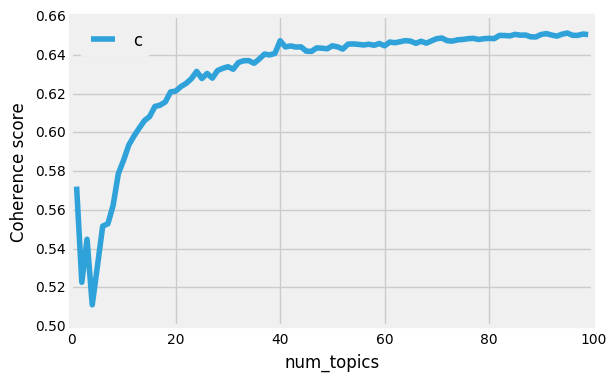

CPU times: user 3min 24s, sys: 410 ms, total: 3min 24s
Wall time: 3min 25s


In [115]:
%%time
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=train_corpus, texts=texts, limit=100,coherence='c_v')

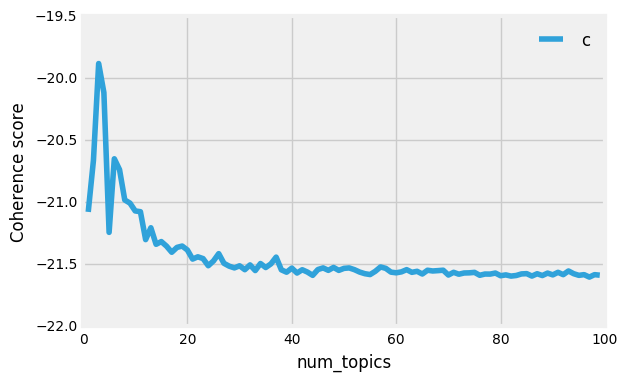

In [53]:
lmlist2, c_v2 = evaluate_graph(dictionary=dictionary, corpus=train_corpus, texts=texts, limit=100,coherence='u_mass')

In [ ]:
lda.show_topics(formatted=False, num_words=20)

In [94]:
with open("final_topics.txt","w") as fp:
    for i in  lda.show_topics():
        #print(i[0], i[1])
        #print(str(i[0]) + " : " + str(i[1]))
        fp.write(str(i[0]) +  ":" + i[1])
        fp.write("\n")

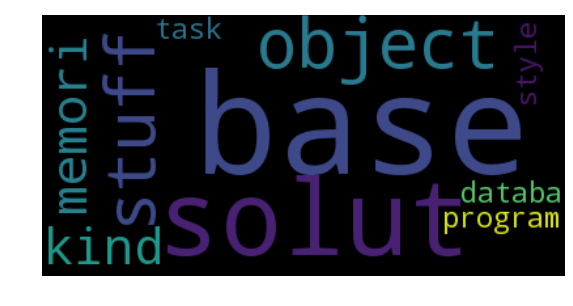

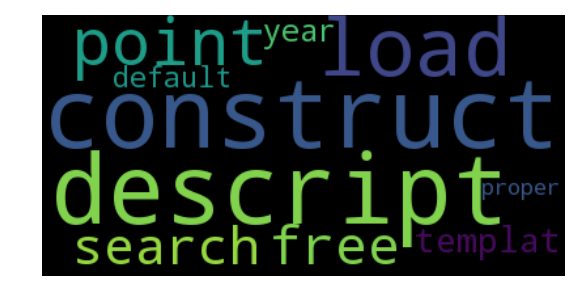

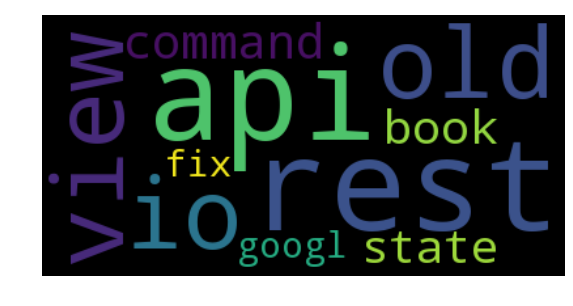

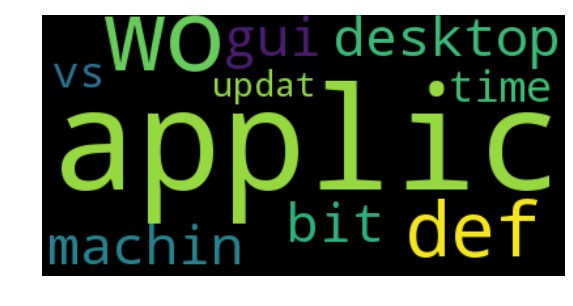

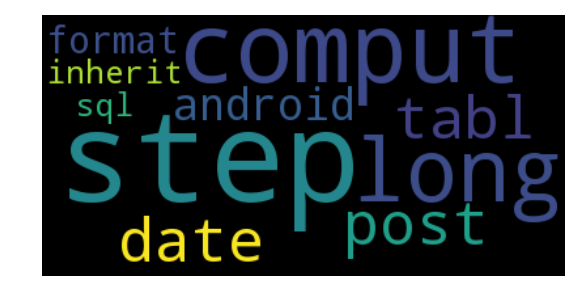

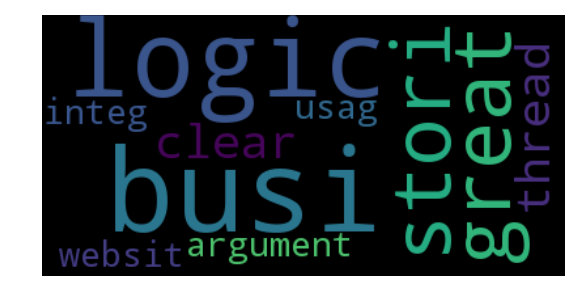

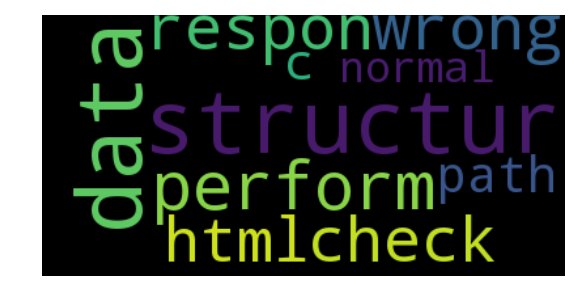

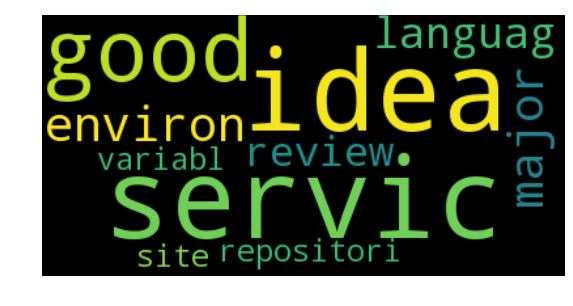

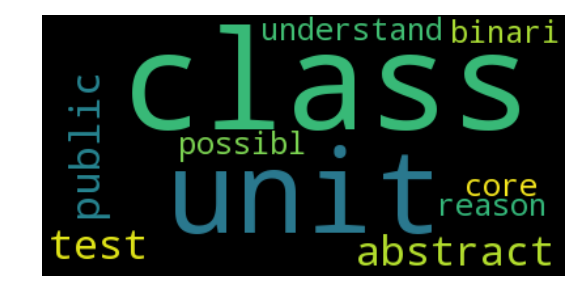

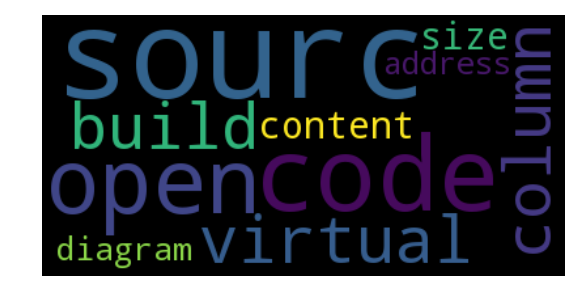

In [100]:
import os
import wordcloud
import matplotlib.pyplot as plt

MODELS_DIR = "."

final_topics = open("final_topics.txt", 'r')
curr_topic = 0
for line in final_topics:
    line = line.strip()[line.rindex(":") + 2:]
    scores = [float(x.split("*")[0]) for x in line.split(" + ")]
    words = [eval(x.split("*")[1]) for x in line.split(" + ")]
    freqs = {}
    for word, score in zip(words, scores):
        freqs[word]= score
    
    elements = WordCloud().fit_words(freqs)
    #wordcloud.draw(elements, "gs_topic_%d.png" % (curr_topic),
    #               width=120, height=120)
    # Display the generated image:
    plt.figure()
    plt.imshow(elements)
    plt.axis("off")
    plt.show()
    curr_topic += 1
final_topics.close()

In [113]:
doc_lda = lda[test_corpus]

In [116]:
perplex = lda.bound(test_corpus) # this is model perplexity not the per word perplexity
print("Total Perplexity: %s" % perplex)

Total Perplexity: -2842.0568238


In [117]:
per_word_perplex = np.exp2(-perplex / number_of_words)
print("Per-word Perplexity: %s" % per_word_perplex)

Per-word Perplexity: 15312701814.2


starting pass for parameter_value = 5.000
Total Perplexity: -1004.49895122
Per-word Perplexity: 3979.36039233
starting pass for parameter_value = 10.000
Total Perplexity: -1261.65321165
Per-word Perplexity: 33218.0805372
starting pass for parameter_value = 15.000
Total Perplexity: -1420.85283625
Per-word Perplexity: 123565.350092
starting pass for parameter_value = 20.000
Total Perplexity: -1538.49180974
Per-word Perplexity: 326195.801464
starting pass for parameter_value = 25.000
Total Perplexity: -1628.57204437
Per-word Perplexity: 685958.814536
starting pass for parameter_value = 30.000
Total Perplexity: -1708.45087623
Per-word Perplexity: 1326047.39282
starting pass for parameter_value = 35.000
Total Perplexity: -1773.91143008
Per-word Perplexity: 2275880.24465
starting pass for parameter_value = 40.000
Total Perplexity: -1829.35894192
Per-word Perplexity: 3596301.741
starting pass for parameter_value = 45.000
Total Perplexity: -1884.35204213
Per-word Perplexity: 5661537.26061
star

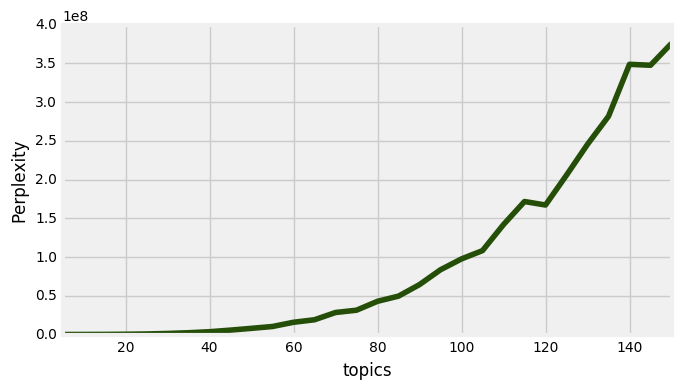

In [124]:
import pandas
number_of_words = sum(cnt for document in test_corpus for _, cnt in document)
parameter_list = range(5, 151, 5)
grid = {}
for parameter_value in parameter_list:
    grid[parameter_value] = []
    print("starting pass for parameter_value = %.3f" % parameter_value)
    model = models.LdaMulticore(corpus=corpus, workers=None, id2word=dictionary, num_topics=parameter_value, iterations=10)
   
    perplex = model.bound(test_corpus) # this is model perplexity not the per word perplexity
    print("Total Perplexity: %s" % perplex)
    grid[parameter_value].append(perplex)

    per_word_perplex = np.exp2(-perplex / number_of_words)
    print("Per-word Perplexity: %s" % per_word_perplex)
    grid[parameter_value].append(per_word_perplex)
    model.save("./" + 'ldaMulticore_i10_T' + str(parameter_value) + '_training_corpus.lda')
    print

for numtopics in parameter_list:
    print(numtopics, '\t',  grid[numtopics])

df = pandas.DataFrame(grid)
ax = plt.figure(figsize=(7, 4), dpi=300).add_subplot(111)
df.iloc[1].transpose().plot(ax=ax,  color="#254F09")
plt.xlim(parameter_list[0], parameter_list[-1])
plt.ylabel('Perplexity')
plt.xlabel('topics')
plt.title('')
plt.savefig('gensim_multicore_i10_topic_perplexity.pdf', format='pdf', bbox_inches='tight', pad_inches=0.1)
plt.show()
df.to_pickle("./" + 'gensim_multicore_i10_topic_perplexity.df')

## LSA on TF-IDF matrix

Input: X, a matrix where m is the number of documents , and n is the number of terms in the vocabulary.
Process: Decompose X into three matricies called U, S, and T. When we do the decomposition, we have to pick a value k, that's how many concepts we are going to keep.
$$X \approx USV^{T}$$
U will be a m x k matrix. The rows will be documents and the columns will be 'concepts'
S will be a k x k diagnal matrix. The elements will be the amount of variation captured from each concept.
V will be a n x k (mind the transpose) matrix. The rows will be terms and the columns will be concepts.

In [17]:
train_matrix.shape

(18000, 422)

In [42]:
from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(n_components=27, n_iter=100)
lsa.fit(train_matrix)

TruncatedSVD(algorithm='randomized', n_components=27, n_iter=100,
       random_state=None, tol=0.0)

In [43]:
terms = tfidf_vectorizer.get_feature_names()
for i, comp in enumerate(lsa.components_): 
    termsInComp = zip (terms,comp)
    sortedTerms =  sorted(termsInComp, key=lambda x: x[1], reverse=True) [:10]
    print("Concept %d:" % i )
    for term in sortedTerms:
        print(term[0])
    print (" ")

Concept 0:
code
class
nt
s
data
c
new
differ
function
applic
 
Concept 1:
class
public
return
method
int
void
string
object
function
static
 
Concept 2:
code
sourc
c
sourc code
project
softwar
test
open sourc
open
licens
 
Concept 3:
c
nt
languag
ca
ca nt
java
function
program
python
type
 
Concept 4:
test
nt
ca
ca nt
unit
unit test
develop
team
softwar
case
 
Concept 5:
nt
ca
ca nt
sourc
file
code
sourc code
licens
data
user
 
Concept 6:
test
data
file
unit
function
unit test
code
databas
user
structur
 
Concept 7:
web
test
applic
code
web applic
nt
unit
unit test
app
ca
 
Concept 8:
file
c
class
test
java
project
text
unit
data
unit test
 
Concept 9:
file
function
int
return
public
user
string
var
develop
valu
 
Concept 10:
function
file
class
design
object
pattern
new
method
web
languag
 
Concept 11:
data
softwar
sourc
function
structur
data structur
open sourc
open
applic
int
 
Concept 12:
project
user
sourc
function
open sourc
open
licens
c
class
test
 
Concept 13:
project
new
dif

In [44]:
doc_topic_distrib = lsa.transform(train_matrix)

In [45]:
doc_topic_distrib

array([[ 0.21672388,  0.02227692, -0.0111975 , ...,  0.00623656,
        -0.016442  , -0.11914884],
       [ 0.14230934, -0.0382193 ,  0.20070055, ...,  0.00063928,
        -0.07339879,  0.02730571],
       [ 0.17752198, -0.03857147,  0.00657868, ..., -0.01004992,
         0.03922895, -0.02146017],
       ..., 
       [ 0.25547295,  0.25093173, -0.01384456, ..., -0.04165741,
        -0.0194877 , -0.04841519],
       [ 0.18832288,  0.25224076, -0.00465802, ..., -0.04556556,
         0.06455899, -0.04687932],
       [ 0.17064855, -0.16091824,  0.0375957 , ...,  0.08090781,
         0.05834837, -0.02098693]])

In [90]:
freqs

{'"background"': 0.03,
 '"concept"': 0.03,
 '"dev"': 0.03,
 '"json"': 0.03,
 '"n"': 0.03,
 '"process"': 0.03,
 '"project"': 0.03,
 '"question"': 0.03,
 '"special"': 0.03,
 '"version"': 0.03}